In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium

In [62]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [63]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [64]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [65]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [66]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [67]:
def train_episode(env, policy, optimizer, gamma, device):
    """Train policy for one episode."""
    policy.train()
    log_prob_actions, rewards, values = [], [], []
    done = False
    state, _ = env.reset()
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_logits, value_pred = policy(state_tensor)
        action_prob = F.softmax(action_logits, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        values.append(value_pred)
        rewards.append(reward)
        state = next_state

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)        
    returns = calculate_returns(rewards, gamma, device, False)
    policy_loss, value_loss = update_policy(returns, log_prob_actions, values, optimizer)
    return policy_loss, value_loss, sum(rewards)

In [68]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [69]:
def update_policy(returns, log_prob_actions, values, optimizer):
    """Compute loss and update policy and value parameters."""    
    # returns = returns.detach()    
    policy_loss = -(returns * log_prob_actions).sum()
    value_loss = F.smooth_l1_loss(returns, values).sum()
    optimizer.zero_grad()
    policy_loss.backward()
    value_loss.backward()
    optimizer.step()
    return policy_loss.item(), value_loss.item()

In [70]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits, value_pred = policy(state_tensor)
            action = torch.argmax(action_logits, dim=-1).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state

    return total_reward

In [71]:
# ----------------------------
# Main experiment
# ----------------------------
train_env = gymnasium.make('CartPole-v1')
test_env = gymnasium.make('CartPole-v1')

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device = get_device()

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic).to(device)
policy.apply(init_weights)

LEARNING_RATE = 0.01
optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    policy_loss, critic_loss, train_reward = train_episode(train_env, policy, optimizer, DISCOUNT_FACTOR, device)
    test_reward = evaluate(test_env, policy, device)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break
print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')


Using device: cuda
| Episode:  10 | Mean Train Rewards:  16.4 | Mean Test Rewards:   9.7 |
| Episode:  20 | Mean Train Rewards:  18.4 | Mean Test Rewards:   9.3 |
| Episode:  30 | Mean Train Rewards:  22.8 | Mean Test Rewards:  26.2 |
| Episode:  40 | Mean Train Rewards:  32.4 | Mean Test Rewards:  88.7 |
| Episode:  50 | Mean Train Rewards:  52.7 | Mean Test Rewards: 167.0 |
| Episode:  60 | Mean Train Rewards:  61.8 | Mean Test Rewards: 218.1 |
| Episode:  70 | Mean Train Rewards:  64.4 | Mean Test Rewards: 225.8 |
| Episode:  80 | Mean Train Rewards:  85.8 | Mean Test Rewards: 223.9 |
| Episode:  90 | Mean Train Rewards: 117.1 | Mean Test Rewards: 229.6 |
| Episode: 100 | Mean Train Rewards: 118.7 | Mean Test Rewards: 230.3 |
| Episode: 110 | Mean Train Rewards: 100.7 | Mean Test Rewards: 152.1 |
| Episode: 120 | Mean Train Rewards:  95.7 | Mean Test Rewards: 127.4 |
| Episode: 130 | Mean Train Rewards:  93.7 | Mean Test Rewards: 110.6 |
| Episode: 140 | Mean Train Rewards:  82.4 | 

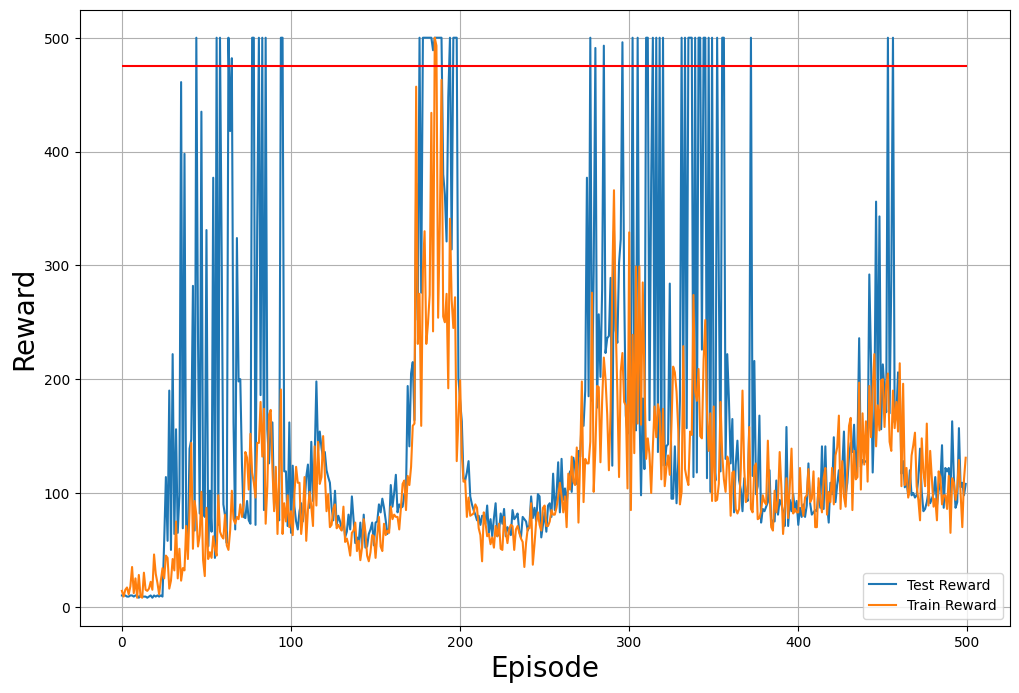

In [72]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()